# 5. How are Climatic Conditions interacting with Wildfires?

We have seen in `notebook 3` that even with only a handful of selected variables it is challenging to analyse and visualize the complex relationships between different factors. The system is largely hidden from us, with only a few sparsely available states that we are able to observe. Let's see if we can obtain evidence towards strong interactions between different environmental factors and the occurrance of wildfires. 

For this purpose the following variables have been obtained from the ERA5 dataset. The variables are given in a frequency of months.

- `tp`: The total precipitation.
- `ssr`: The net solar radiation influx.
- `swvl1`: The water volume contained in the top most layer of soil.
- `skt`: The surface (or skin) temperature.
- `windspeed`: The average windspeed at 10m height (Composed from `u10` and `v10`).

In [1]:
import pickle

with open("../data/all_data_processed.pkl", "rb") as datafile:
    data = pickle.load(datafile)

## 5.1 The hypothesis

This notebook is testing the following hypothesis.

*`H2: More heat, less rain and strong winds imply more severe fires.`*

So essentially we want to show a strong correlation between these factors and the occuring wildfires.

## 5.2 The analysis

A good measure to test our hypothesis is the correlation between these variables and the target `burned_area`. However, there are a few things that we need to keep in mind.

First of all, the meteorological physics of our planet are far from being linear. Thus, testing for the commonly used `Pearson-Correlation` does not make a lot of sense, as we do not necessarily expect to see a linear relationship and also the `burned_area` data does not look like its normal distributed. We can forego these limitations by employing the `Spearman-Correlation`, which tests for monotony between two datasets and has less requirements towards its inputs. The corresponding implementation of scipy does also calculate the `pvalue` for null-hypotheses, which suggests that the two inputs are completely uncorrelated. This is exactly what we want to disprove.

Furthermore, the relationships between these environmental factors might not be immediate, so it is a good idea to test the correlation including a variable time lag. For this reason, we will introduce a lag of up to 12 months into the calculation.

In [4]:
import numpy as np
from scipy.stats import spearmanr
import math 

n_lon = data["lon"].shape[0]
n_lat = data["lat"].shape[0]

vars = ["tp","windspeed","skt","ssr","swvl1"]
lags = [l for l in range(13)]

result = {}
for var in vars:
    result[var] = []
    
for var in vars:
    for lag in lags:
        # collect results for all grid cells at a given lag and var
        correlations = []
        for lo in range(n_lon):
            for la in range(n_lat):
                y = data[var][lag:, la, lo]
                if lag:
                    x = data["burned_area"][:-lag, la, lo]
                else:
                    x = data["burned_area"][:, la, lo]
                r = spearmanr(x,y)
                if not math.isnan(r.correlation):
                    correlations.append(r)
        # condense results
        r_mean = np.mean([r.correlation for r in correlations])
        r_std = np.std([r.correlation for r in correlations])
        p_mean = np.mean([r.pvalue for r in correlations])
        p_std = np.std([r.pvalue for r in correlations])
        # append per lag
        result[var].append((r_mean,r_std,p_mean,p_std))

Great, we have collected all the results. Let's go through the collected data and see if we hit any statistically significant correllations. If the `pvalue` is small enough, we will be able to reject our `H0: The selected environmental factors are uncorrelated with the amount of burned area in Sardinia.`. Typically the threshold is around `p<0.05`.

In [7]:
thresh = 0.05

print("Smallest p-values of Spearman Correlation against `burned_area`")
print("---")
for var in vars:
    pvalues = [c for (a,b,c,d) in result[var]]
    lag_min = np.argmin(pvalues)
    p_min = pvalues[lag_min]
    print(f"burned_area vs. {var:10s} at a lag of {lag_min:2d} months results in a p-value of {p_min:0.4f}. This means {'H0 is rejected.' if p_min <= thresh else 'H2 is rejected.'}")

Smallest p-values of Spearman Correlation against `burned_area`
---
burned_area vs. tp         at a lag of  0 months results in a p-value of 0.1087. This means H2 is rejected.
burned_area vs. windspeed  at a lag of  6 months results in a p-value of 0.3283. This means H2 is rejected.
burned_area vs. skt        at a lag of  0 months results in a p-value of 0.0731. This means H2 is rejected.
burned_area vs. ssr        at a lag of 11 months results in a p-value of 0.0917. This means H2 is rejected.
burned_area vs. swvl1      at a lag of  0 months results in a p-value of 0.1094. This means H2 is rejected.


According to our test results, we technically also need to reject our second hypothesis `H2: More heat, less rain and strong winds imply more severe fires`. None of the correlations were strong enough to support our hypothesis. However, some correlations are close to being significantly correlated as the `skt`and `ssr` in example.

Let's plot the Spearman correlation for each variable against the `burned_area` in **Figure 5.1**, despite our low confidence in the results. We will use the `pvalue` as the alpha channel. This way the bar plot will get less visible if the chance increases that the results could have been obtained by two randomly uncorrelated datasets. Finally, we will give the standard deviation of the correlation value, as we have obtained these correlations for all `80` grid cells and highlight the correlation with the most significance with a green border.

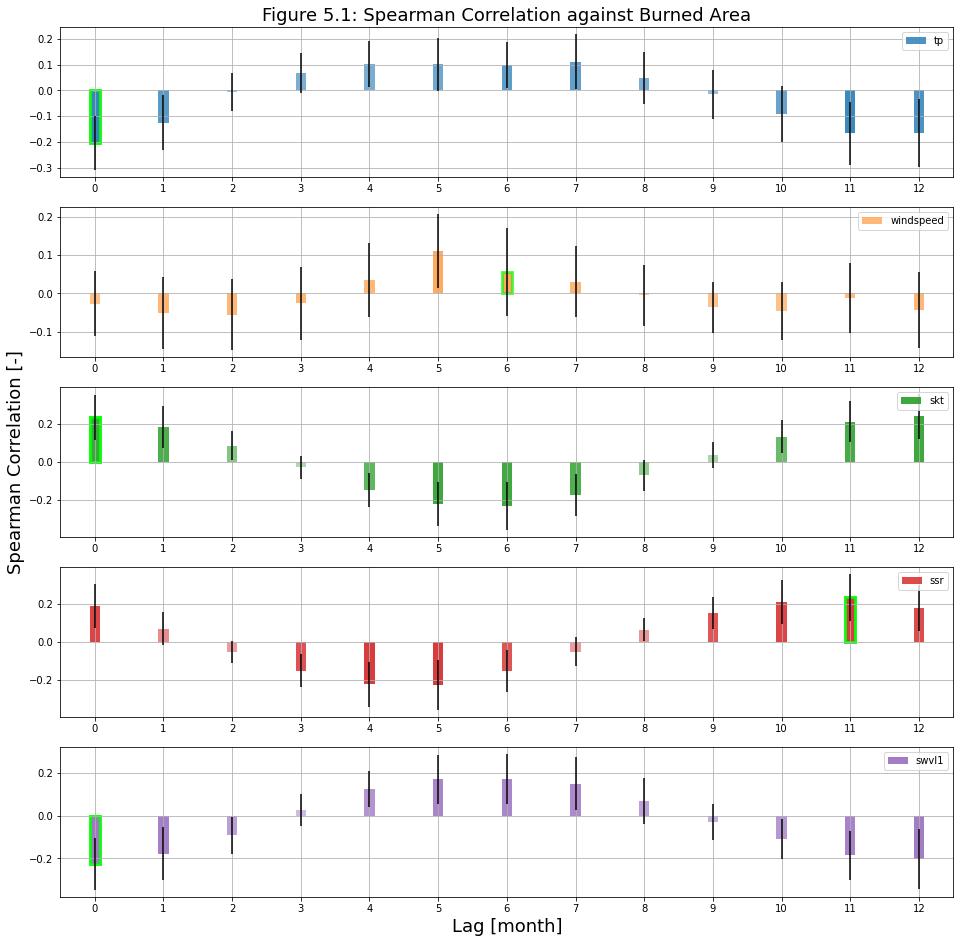

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,16))

n_vars = len(vars)

for idx, var in enumerate(vars):
    plt.subplot(511+idx)
    r_means = np.asarray([a for (a,b,c,d) in result[var]])
    r_stds = np.asarray([b for (a,b,c,d) in result[var]])
    pvalue = [c for (a,b,c,d) in result[var]]
    idx_p_max = np.argmin(pvalue)
    
    for l in lags:
        if l == 12:
            label = label=var
        else:
            label = None
            
        if l == idx_p_max:
            edgecolor = "lime"
            lw = 3
        else:
            edgecolor = None
            lw = None
        
        plt.bar(lags[l], r_means[l], width=0.15, label=label, edgecolor=edgecolor, lw=lw,
                yerr=r_stds[l], color=f"C{idx}", alpha=np.abs(1-pvalue[l]) ) 
        
    plt.grid()
    plt.xticks(np.arange(13))
    plt.legend()
    
    if idx == 0:
        plt.title("Figure 5.1: Spearman Correlation against Burned Area", fontsize=18)
    if idx == 2:
        plt.ylabel("Spearman Correlation [-]", fontsize=18)
    if idx == n_vars-1:
        plt.xlabel("Lag [month]", fontsize=18)
    _ = plt.xlim([-0.5,12.5])

Although these results are not statistically significant, they seem to point in the direction of our hypothesis. `More heat`, meaning increases in the skin temperature `skt` and solar radiation `ssr` are positively correlated with the `burned_area`. `Less water` is also indicated by negative correlation values for the total precipitation `tp`and the soil water volume `swvl1`. Finally, the `windspeed`does not show any clear correlation at `lag==0`. The results seem to be periodic, given the lag of up to a year. This makes a lot of sense, since the temperature and precipitation are on average seasonally repeating every year.